**Group 10 Team Members :-
Fady Nasser - 
Omar Hisham - 
Saieed Osama**

In [1]:
# Adding Imports
import pandas as pd
import numpy as np
import os
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFE
import xml.etree.ElementTree as ET

In [2]:
# Dataset Path
dataset_path = '/kaggle/input/car-crashes-severity-prediction'

# Load Training Dataset
df = pd.read_csv(os.path.join(dataset_path, 'train.csv'))

# Data PreProcessing 
df = df*1 # To Convert True And False to Int
df['Side'] = df['Side'].replace({'R': 0, 'L': 1})
df['Year'] = pd.DatetimeIndex(df['timestamp']).year
df['Month'] = pd.DatetimeIndex(df['timestamp']).month
df['Day'] = pd.DatetimeIndex(df['timestamp']).day
df['Hour'] = pd.DatetimeIndex(df['timestamp']).hour
df['Quarter'] = pd.DatetimeIndex(df['timestamp']).quarter
df['WeekDay'] = pd.DatetimeIndex(df['timestamp']).dayofweek
df['WeekYear'] = pd.DatetimeIndex(df['timestamp']).weekofyear
df['WeekEnd'] = np.where(df['WeekDay'] < 5  , 0, 1)
df['Morning_Midnight'] = np.where((df['Hour'] >= 6) & (df['Hour'] < 18) , 0, 1)
df['Summer_Winter'] = np.where((df['Month'] >= 5) & (df['Month'] < 11) , 0, 1)
df['Lat'] = df['Lat'] - np.mean(df['Lat'])
df['Lng'] = df['Lng'] - np.mean(df['Lng'])

print(df.shape)
df.head()

(6407, 26)


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:16: FutureWarning: weekofyear and week have been deprecated, please use DatetimeIndex.isocalendar().week instead, which returns a Series.  To exactly reproduce the behavior of week and weekofyear and return an Index, you may call pd.Int64Index(idx.isocalendar().week)
  app.launch_new_instance()


,ID,Lat,Lng,Bump,Distance(mi),Crossing,Give_Way,Junction,No_Exit,Railway,...,Year,Month,Day,Hour,Quarter,WeekDay,WeekYear,WeekEnd,Morning_Midnight,Summer_Winter
0,0,-0.003503,0.000330,0,0.044,0,0,0,0,0,...,2016,3,25,15,1,4,12,0,0,1
1,1,-0.046496,-0.042264,0,0.000,0,0,0,0,0,...,2020,5,5,19,2,1,19,0,1,0
2,2,0.042845,0.039138,0,0.000,0,0,0,0,0,...,2016,9,16,19,3,4,37,0,1,0
3,3,0.020277,0.014910,0,0.009,0,0,1,0,0,...,2020,3,29,19,1,6,13,1,1,1
4,4,-0.046512,-0.042467,0,0.000,0,0,0,0,0,...,2019,10,9,8,4,2,41,0,0,0


In [3]:
# Load Weather Dataset
Weather_df = pd.read_csv(os.path.join(dataset_path, 'weather-sfcsv.csv'))
Weather_df['Selected'] = Weather_df['Selected'].replace({'No': 0, 'Yes': 1})
Weather_df.Weather_Condition = pd.Categorical(Weather_df.Weather_Condition)
Weather_df['Weather_Condition_Code'] = Weather_df.Weather_Condition.cat.codes

print(Weather_df.shape)

Weather_df.drop(columns=['Weather_Condition'],inplace=True)
Weather_df.fillna(Weather_df.mean(), inplace=True)
Weather_df = Weather_df.sort_values(['Year','Month','Day','Hour'])
Weather_df.drop_duplicates(subset =['Year','Month','Day','Hour'],keep = 'first', inplace = True)

print(Weather_df.shape)
Weather_df.head()

(6901, 13)
(5972, 12)


,Year,Day,Month,Hour,Wind_Chill(F),Precipitation(in),Temperature(F),Humidity(%),Wind_Speed(mph),Visibility(mi),Selected,Weather_Condition_Code
5724,2016,23,3,9,59.762515,0.006444,55.9,75.0,10.813164,10.0,0,14
1053,2016,23,3,16,59.762515,0.006444,61.0,62.0,20.700000,10.0,0,14
3329,2016,23,3,20,59.762515,0.006444,59.0,67.0,12.700000,10.0,0,22
3813,2016,24,3,8,59.762515,0.006444,55.0,80.0,6.900000,10.0,0,17
401,2016,24,3,9,59.762515,0.006444,55.9,77.0,3.500000,10.0,0,17


In [4]:
# Merge Train Dataset with Weather Dataset
Merged_df = pd.merge(df,Weather_df,on=['Year','Month','Day','Hour'],how="inner")
Merged_df.head()

,ID,Lat,Lng,Bump,Distance(mi),Crossing,Give_Way,Junction,No_Exit,Railway,...,Morning_Midnight,Summer_Winter,Wind_Chill(F),Precipitation(in),Temperature(F),Humidity(%),Wind_Speed(mph),Visibility(mi),Selected,Weather_Condition_Code
0,0,-0.003503,0.000330,0,0.044,0,0,0,0,0,...,0,1,59.762515,0.006444,64.0,58.0,23.0,10.0,0,22
1,803,-0.003503,0.000330,0,0.044,0,0,0,0,0,...,0,1,59.762515,0.006444,64.0,58.0,23.0,10.0,0,22
2,4522,-0.013333,0.002960,0,0.306,0,0,0,0,0,...,0,1,59.762515,0.006444,64.0,58.0,23.0,10.0,0,22
3,1,-0.046496,-0.042264,0,0.000,0,0,0,0,0,...,1,0,57.000000,0.000000,57.0,83.0,22.0,10.0,0,15
4,3174,-0.046503,-0.042270,0,0.025,0,0,0,0,0,...,1,0,57.000000,0.000000,57.0,83.0,22.0,10.0,0,15


In [5]:
# Load Holiday Dataset
root = ET.parse(os.path.join(dataset_path,'holidays.xml')).getroot()
tags = {"tags":[]}

for elem in root:
    tag = {"date": elem.getchildren()[0].text, "description": elem.getchildren()[1].text}
    tags["tags"].append(tag)

df_holidays = pd.DataFrame(tags["tags"])
df_holidays['Year'] = pd.DatetimeIndex(df_holidays['date']).year
df_holidays['Month'] = pd.DatetimeIndex(df_holidays['date']).month
df_holidays['Day'] = pd.DatetimeIndex(df_holidays['date']).day
df_holidays['Is_Holiday'] = 1

print(df_holidays.shape)
df_holidays.head()

(90, 6)


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: This method will be removed in future versions.  Use 'list(elem)' or iteration over elem instead.
  


,date,description,Year,Month,Day,Is_Holiday
0,2012-01-02,New Year Day,2012,1,2,1
1,2012-01-16,Martin Luther King Jr. Day,2012,1,16,1
2,2012-02-20,Presidents Day (Washingtons Birthday),2012,2,20,1
3,2012-05-28,Memorial Day,2012,5,28,1
4,2012-07-04,Independence Day,2012,7,4,1


In [6]:
# Prepaing the final dataset for preprocessing
# Final_df = pd.merge(Merged_df,df_holidays,on=['Year','Month','Day'],how="left")
Final_df = Merged_df

print(Final_df.shape)

Final_df.replace(np.nan,0)
Final_df = Final_df.drop(columns=['timestamp','Bump','Give_Way','No_Exit','Roundabout','Selected'])

print(Final_df.shape)

Final_df.head()
Final_df.drop(columns='ID').describe()

(6407, 34)
(6407, 28)


,Lat,Lng,Distance(mi),Crossing,Junction,Railway,Stop,Amenity,Side,Severity,...,WeekEnd,Morning_Midnight,Summer_Winter,Wind_Chill(F),Precipitation(in),Temperature(F),Humidity(%),Wind_Speed(mph),Visibility(mi),Weather_Condition_Code
count,6.407000e+03,6.407000e+03,6407.000000,6407.00000,6407.000000,6407.000000,6407.000000,6407.000000,6407.000000,6407.000000,...,6407.000000,6407.000000,6407.000000,6407.000000,6407.000000,6407.00000,6407.000000,6407.000000,6407.000000,6407.000000
mean,1.338431e-13,7.422028e-13,0.135189,0.08241,0.246449,0.026533,0.097706,0.037147,0.050726,2.293429,...,0.188544,0.361948,0.524739,59.851594,0.006325,59.93899,68.179669,10.864850,9.440442,11.079132
std,3.255477e-02,2.827490e-02,0.396360,0.27501,0.430977,0.160728,0.296939,0.189136,0.219454,0.521225,...,0.391176,0.480601,0.499427,6.549706,0.020930,7.94523,16.163415,6.348389,1.647513,6.906617
min,-1.560338e-01,-1.044497e-01,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,...,0.000000,0.000000,0.000000,31.100000,0.000000,36.00000,10.000000,0.000000,0.120000,-1.000000
25%,-2.855627e-02,-6.219667e-03,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,...,0.000000,0.000000,0.000000,59.000000,0.000000,54.00000,59.000000,6.000000,10.000000,3.000000
50%,2.585235e-03,1.155333e-03,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,...,0.000000,0.000000,1.000000,59.762515,0.006444,59.00000,70.000000,10.000000,10.000000,14.000000
75%,2.216073e-02,1.351283e-02,0.041000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000,...,0.000000,1.000000,1.000000,59.762515,0.006444,64.90000,80.000000,15.000000,10.000000,17.000000
max,5.997323e-02,5.625633e-02,6.820000,1.00000,1.000000,1.000000,1.000000,1.000000,1.000000,4.000000,...,1.000000,1.000000,1.000000,98.000000,0.490000,98.00000,100.000000,40.300000,10.000000,25.000000


Lat 2
Lng 1
Distance(mi) 4
Crossing 9
Junction 25
Railway 26
Stop 3
Amenity 21
Side 19
Year 5
Month 10
Day 23
Hour 11
Quarter 16
WeekDay 17
WeekYear 7
WeekEnd 13
Morning_Midnight 18
Summer_Winter 24
Wind_Chill(F) 8
Precipitation(in) 6
Temperature(F) 22
Humidity(%) 14
Wind_Speed(mph) 15
Visibility(mi) 20
Weather_Condition_Code 12


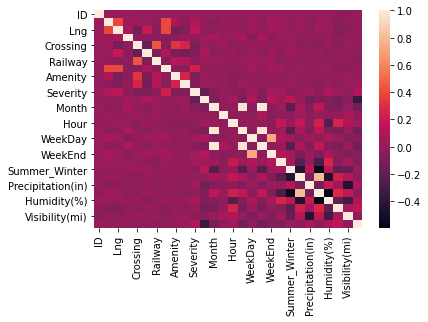

In [7]:
# Calculate The heatmap and the rank of each generated feature
sns.heatmap(Final_df.corr())

estimator =  RandomForestClassifier(max_depth=2, random_state=0)
selector = RFE(estimator, n_features_to_select=1, step=1)
selector = selector.fit(Final_df.drop(columns=['Severity','ID']), Final_df['Severity'])

for i in range(len(Final_df.drop(columns=['Severity','ID']).columns)):
    print(list(Final_df.drop(columns=['Severity','ID']).columns)[i], selector.ranking_[i])

In [8]:
# Split Data For Training
train_df, val_df = train_test_split(Final_df, test_size=0.2, random_state=42)

# Top Features :- ['Lng','Lat','Stop','Distance(mi)','Year','Precipitation(in)', 'Wind_Chill(F)', 'Crossing']
X_train = train_df[['Lat', 'Lng', 'Crossing', 'Stop', 'Year', 'Wind_Chill(F)', 'Precipitation(in)']]
y_train = train_df['Severity']

X_val = val_df[['Lat', 'Lng', 'Crossing', 'Stop', 'Year', 'Wind_Chill(F)', 'Precipitation(in)']]
y_val = val_df['Severity']

In [9]:
# Create an instance of the classifier model
classifier = RandomForestClassifier(max_depth=2, random_state=0)
classifier = classifier.fit(X_train, y_train)
print("The accuracy of the classifier on the validation set is ", (classifier.score(X_val, y_val)))

The accuracy of the classifier on the validation set is  0.7527301092043682


In [10]:
# Load Testing Dataset
test_df = pd.read_csv(os.path.join(dataset_path, 'test.csv'))
test_df = test_df*1

test_df['Side'] = test_df['Side'].replace({'R': 0, 'L': 1})
test_df['Year'] = pd.DatetimeIndex(test_df['timestamp']).year
test_df['Month'] = pd.DatetimeIndex(test_df['timestamp']).month
test_df['Day'] = pd.DatetimeIndex(test_df['timestamp']).day
test_df['Hour'] = pd.DatetimeIndex(test_df['timestamp']).hour
test_df['Quarter'] = pd.DatetimeIndex(test_df['timestamp']).quarter
test_df['WeekDay'] = pd.DatetimeIndex(test_df['timestamp']).dayofweek
test_df['WeekYear'] = pd.DatetimeIndex(test_df['timestamp']).weekofyear
test_df['WeekEnd'] = np.where(test_df['WeekDay'] < 5  , 0, 1)
test_df['Morning_Midnight'] = np.where((test_df['Hour'] >= 6) & (test_df['Hour'] < 18) , 0, 1)
test_df['Summer_Winter'] = np.where((test_df['Month'] >= 5) & (test_df['Month'] < 11) , 0, 1)
test_df['Lat'] = test_df['Lat'] - np.mean(test_df['Lat'])
test_df['Lng'] = test_df['Lng'] - np.mean(test_df['Lng'])

print(df.shape)
df.head()

(6407, 26)


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: FutureWarning: weekofyear and week have been deprecated, please use DatetimeIndex.isocalendar().week instead, which returns a Series.  To exactly reproduce the behavior of week and weekofyear and return an Index, you may call pd.Int64Index(idx.isocalendar().week)
  if sys.path[0] == '':


,ID,Lat,Lng,Bump,Distance(mi),Crossing,Give_Way,Junction,No_Exit,Railway,...,Year,Month,Day,Hour,Quarter,WeekDay,WeekYear,WeekEnd,Morning_Midnight,Summer_Winter
0,0,-0.003503,0.000330,0,0.044,0,0,0,0,0,...,2016,3,25,15,1,4,12,0,0,1
1,1,-0.046496,-0.042264,0,0.000,0,0,0,0,0,...,2020,5,5,19,2,1,19,0,1,0
2,2,0.042845,0.039138,0,0.000,0,0,0,0,0,...,2016,9,16,19,3,4,37,0,1,0
3,3,0.020277,0.014910,0,0.009,0,0,1,0,0,...,2020,3,29,19,1,6,13,1,1,1
4,4,-0.046512,-0.042467,0,0.000,0,0,0,0,0,...,2019,10,9,8,4,2,41,0,0,0


In [11]:
# Merge Test Dataset with Weather Dataset
test_df = pd.merge(test_df,Weather_df,on=['Year','Month','Day','Hour'],how="inner")

print(test_df.shape)

test_df.replace(np.nan,0)
test_df = test_df.drop(columns=['timestamp','Bump','Give_Way','No_Exit','Roundabout','Selected'])

print(test_df.shape)

(1601, 33)
(1601, 27)


In [12]:
# Spliting Data For Testing
X_test = test_df[['Lat', 'Lng', 'Crossing', 'Stop', 'Year', 'Wind_Chill(F)', 'Precipitation(in)']]

# Predict The Output
y_test_predicted = classifier.predict(X_test)
test_df['Severity'] = y_test_predicted
test_df.head()

,ID,Lat,Lng,Distance(mi),Crossing,Junction,Railway,Stop,Amenity,Side,...,Morning_Midnight,Summer_Winter,Wind_Chill(F),Precipitation(in),Temperature(F),Humidity(%),Wind_Speed(mph),Visibility(mi),Weather_Condition_Code,Severity
0,6407,0.020508,0.015150,0.039,0,1,0,0,0,0,...,1,1,59.762515,0.006444,63.0,60.0,10.4,10.0,17,2
1,6408,0.004057,-0.009007,0.202,0,0,0,0,0,0,...,0,0,65.000000,0.000000,65.0,56.0,5.0,9.0,3,2
2,6693,0.004033,-0.008132,0.316,0,0,0,0,0,0,...,0,0,65.000000,0.000000,65.0,56.0,5.0,9.0,3,2
3,7194,0.004117,-0.010059,0.214,0,0,0,0,0,0,...,0,0,65.000000,0.000000,65.0,56.0,5.0,9.0,3,2
4,6409,0.041943,-0.069971,0.000,0,0,0,0,0,0,...,0,0,58.000000,0.000000,58.0,90.0,18.0,10.0,14,2


In [13]:
# Extracting the Submission.csv file
test_df[['ID', 'Severity']].to_csv('/kaggle/working/submission.csv', index=False)